# Tratamento de Dados

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os

db_path = os.path.abspath("../../data/brasileirao.db")

engine = create_engine(f"sqlite:///{db_path}")

df = pd.read_sql_query("SELECT * FROM jogos_historico", con=engine)
df_atual = pd.read_sql_query("SELECT * FROM jogos_atual", con=engine)


### Tratando tabela de jogos historicos até 2014

In [2]:
import re

df["data"] = pd.to_datetime(df["data"], errors = "coerce")
df['data_hora'] = pd.to_datetime(df['data'].dt.strftime('%Y-%m-%d') + ' ' + df['hora'].astype(str), errors='coerce')
df['rodada'] = pd.to_numeric(df['rodada'], errors='coerce').astype('Int64')
df["publico"] = (df["publico"].astype(str).str.replace(",", "").str.replace(".", ""))
df["publico"] = pd.to_numeric(df["publico"], errors = "coerce").astype("Int64")

# Extrair gols do placar
def extrair_gols(placar):
    if isinstance(placar, str):
        placar = placar.strip()
        # Substituir travessão por 'x' ou '-' para padronizar
        placar = placar.replace('\u2013', 'x').replace('–', 'x')  # Adicional para garantir
        if re.match(r'^\d+x\d+$', placar):
            gols = placar.split('x')
            return int(gols[0]), int(gols[1])
    return None, None

df[['gols_mandante', 'gols_visitante']] = df['placar'].apply(
    lambda x: pd.Series(extrair_gols(x))
)

df['gols_mandante'] = df['gols_mandante'].astype('Int64')
df['gols_visitante'] = df['gols_visitante'].astype('Int64')
df['total_gols'] = (df['gols_mandante'] + df['gols_visitante']).astype('Int64')

def resultado_partida(row):
    if pd.isna(row['gols_mandante']) or pd.isna(row['gols_visitante']):
        return None
    if row['gols_mandante'] > row['gols_visitante']:
        return 'mandante'
    elif row['gols_mandante'] < row['gols_visitante']:
        return 'visitante'
    else:
        return 'empate'

df['resultado_partida'] = df.apply(resultado_partida, axis=1)

colunas_modelo = [
    'temporada', 'rodada', 'dia_semana', 'data_hora', 'estadio',
    'publico', 'mandante', 'visitante', 'gols_mandante',
    'gols_visitante', 'total_gols', 'resultado_partida'
]

df_modelo = df[colunas_modelo]

# Remover linhas com estádio nulo
df_modelo = df_modelo.dropna(subset=['estadio']).reset_index(drop=True)
print(f"Total de partidas após remoção de estádio nulo: {df_modelo.shape[0]}")
df_modelo['publico'] = df_modelo['publico'].fillna(0).astype('Int64')
df_modelo['hora_hora'] = df_modelo['data_hora'].dt.hour
df_modelo.head()


Total de partidas após remoção de estádio nulo: 4179


,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora
0,2014,1,sáb,2014-04-19 18:30:00,Estadio Jornalista Mário Filho,35020,Fluminense,Figueirense,3,0,3,mandante,18
1,2014,1,sáb,2014-04-19 18:30:00,Estádio José Pinheiro Borba,21983,Internacional,Vitória,1,0,1,mandante,18
2,2014,1,dom,2014-04-20 16:00:00,Estádio Municipal João Havelange,8724,Atlético Mineiro,Corinthians,0,0,0,empate,16
3,2014,1,dom,2014-04-20 16:00:00,Estádio do Morumbi,31564,São Paulo,Botafogo (RJ),3,0,3,mandante,16
4,2014,1,dom,2014-04-20 16:00:00,Itaipava Arena Fonte Nova,9348,Bahia,Cruzeiro,1,2,3,visitante,16


### Tratando tabela de jogos históricos temporada atual

In [3]:
# --- Preparar datas ---
df_atual["data"] = pd.to_datetime(df_atual["data"], errors="coerce")
df_atual['data_hora'] = pd.to_datetime(
    df_atual['data'].dt.strftime('%Y-%m-%d') + ' ' + df_atual['hora'].astype(str), 
    errors='coerce'
)

# --- Ajustar tipos ---
df_atual['rodada'] = pd.to_numeric(df_atual['rodada'], errors='coerce').astype('Int64')
df_atual["publico"] = (df_atual["publico"].astype(str).str.replace(",", "").str.replace(".", ""))
df_atual["publico"] = pd.to_numeric(df_atual["publico"], errors="coerce").astype("Int64")

# --- Extrair gols do placar ---
def extrair_gols(placar):
    if isinstance(placar, str):
        placar = placar.strip()
        placar = placar.replace('\u2013', 'x').replace('–', 'x')
        if re.match(r'^\d+x\d+$', placar):
            gols = placar.split('x')
            return int(gols[0]), int(gols[1])
    return None, None

df_atual[['gols_mandante', 'gols_visitante']] = df_atual['placar'].apply(
    lambda x: pd.Series(extrair_gols(x))
)

df_atual['gols_mandante'] = df_atual['gols_mandante'].astype('Int64')
df_atual['gols_visitante'] = df_atual['gols_visitante'].astype('Int64')
df_atual['total_gols'] = (df_atual['gols_mandante'] + df_atual['gols_visitante']).astype('Int64')

# --- Calcular resultado ---
def resultado_partida(row):
    if pd.isna(row['gols_mandante']) or pd.isna(row['gols_visitante']):
        return None
    if row['gols_mandante'] > row['gols_visitante']:
        return 'mandante'
    elif row['gols_mandante'] < row['gols_visitante']:
        return 'visitante'
    else:
        return 'empate'

df_atual['resultado_partida'] = df_atual.apply(resultado_partida, axis=1)

# --- Selecionar colunas iguais ao df_modelo ---
colunas_modelo = [
    'temporada', 'rodada', 'dia_semana', 'data_hora', 'estadio',
    'publico', 'mandante', 'visitante', 'gols_mandante',
    'gols_visitante', 'total_gols', 'resultado_partida'
]

df_atual_modelo = df_atual[colunas_modelo].copy()

# --- Limpar dados ---
#df_atual_modelo = df_atual_modelo.dropna(subset=['estadio']).reset_index(drop=True)
df_atual_modelo['publico'] = df_atual_modelo['publico'].fillna(0).astype('Int64')
df_atual_modelo['hora_hora'] = df_atual_modelo['data_hora'].dt.hour

print(f"Total de partidas 2025 após limpeza: {df_atual_modelo.shape[0]}")

df_atual_modelo.head()


Total de partidas 2025 após limpeza: 380


,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora
0,2025,1,sáb,2025-03-29 18:30:00,Estádio do Morumbi,0,São Paulo,Sport Recife,0,0,0,empate,18.0
1,2025,1,sáb,2025-03-29 18:30:00,Estádio Alfredo Jaconi,0,Juventude,Vitória,2,0,2,mandante,18.0
2,2025,1,sáb,2025-03-29 18:30:00,Estádio Castelão,0,Fortaleza,Fluminense,2,0,2,mandante,18.0
3,2025,1,sáb,2025-03-29 18:30:00,Estádio Governador Magalhães Pinto,40837,Cruzeiro,Mirassol,2,1,3,mandante,18.0
4,2025,1,sáb,2025-03-29 18:30:00,Arena do Grêmio,0,Grêmio,Atlético Mineiro,2,1,3,mandante,18.0


### Separando jogos já realizados de jogos a realizar

In [4]:
# Jogos já realizados (tem placar preenchido)
df_jogos_realizados = df_atual_modelo.dropna(subset=['gols_mandante', 'gols_visitante']).reset_index(drop=True)

# Jogos a realizar (sem placar ainda)
df_jogos_a_realizar = df_atual_modelo[
    df_atual_modelo['gols_mandante'].isna() | df_atual_modelo['gols_visitante'].isna()
].reset_index(drop=True)

print(f"Jogos já realizados 2025: {df_jogos_realizados.shape[0]}")

Jogos já realizados 2025: 60


In [5]:
# Garantir que colunas estão alinhadas (devem estar, porque usamos colunas_modelo em ambos)
print("Colunas df_modelo:", df_modelo.columns.tolist())
print("Colunas df_jogos_realizados:", df_jogos_realizados.columns.tolist())

# Concatenar os dois
df_historico_completo = pd.concat([df_modelo, df_jogos_realizados], ignore_index=True)

# Conferir resultado final
print(f"Total de partidas no histórico consolidado (2014–2025): {df_historico_completo.shape[0]}")

# Ver últimas linhas para garantir que jogos de 2025 entraram
df_historico_completo.tail()


Colunas df_modelo: ['temporada', 'rodada', 'dia_semana', 'data_hora', 'estadio', 'publico', 'mandante', 'visitante', 'gols_mandante', 'gols_visitante', 'total_gols', 'resultado_partida', 'hora_hora']
Colunas df_jogos_realizados: ['temporada', 'rodada', 'dia_semana', 'data_hora', 'estadio', 'publico', 'mandante', 'visitante', 'gols_mandante', 'gols_visitante', 'total_gols', 'resultado_partida', 'hora_hora']
Total de partidas no histórico consolidado (2014–2025): 4239


,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora
4234,2025,6,dom,2025-04-27 18:30:00,Estádio Manoel Barradas,18688,Vitória,Grêmio,1,1,2,empate,18.0
4235,2025,6,dom,2025-04-27 18:30:00,Estádio Municipal Parque do Sabiá,0,Cruzeiro,Vasco da Gama,1,0,1,mandante,18.0
4236,2025,6,dom,2025-04-27 18:30:00,Allianz Parque,29033,Palmeiras,Bahia,0,1,1,visitante,18.0
4237,2025,6,dom,2025-04-27 20:30:00,Estádio Urbano Caldeira,7679,Santos,RB Bragantino,1,2,3,visitante,20.0
4238,2025,6,sáb,2025-04-26 21:00:00,Estádio Nilton Santos,0,Botafogo (RJ),Fluminense,2,0,2,mandante,21.0


### Jogos rodada atual

In [6]:
df_rodada_atual = df_jogos_a_realizar[df_jogos_a_realizar["rodada"] == 7]
df_rodada_atual


,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora
0,2025,7,sáb,2025-05-03 18:30:00,Estadio Jornalista Mário Filho,0,Fluminense,Sport Recife,<NA>,<NA>,<NA>,None,18.0
1,2025,7,sáb,2025-05-03 18:30:00,Estádio Municipal Presidente Getúlio Var...,0,Ceará,Vitória,<NA>,<NA>,<NA>,None,18.0
2,2025,7,sáb,2025-05-03 18:30:00,Neo Química Arena,0,Corinthians,Internacional,<NA>,<NA>,<NA>,None,18.0
3,2025,7,sex,2025-05-02 21:30:00,Estádio do Morumbi,0,São Paulo,Fortaleza,<NA>,<NA>,<NA>,None,21.0
4,2025,7,dom,2025-05-04 16:00:00,Arena do Grêmio,0,Grêmio,Santos,<NA>,<NA>,<NA>,None,16.0
5,2025,7,dom,2025-05-04 16:00:00,Estádio Nacional de Brasília,0,Vasco da Gama,Palmeiras,<NA>,<NA>,<NA>,None,16.0
6,2025,7,dom,2025-05-04 18:30:00,Estádio Governador Magalhães Pinto,0,Cruzeiro,Flamengo,<NA>,<NA>,<NA>,None,18.0
7,2025,7,sáb,2025-05-03 21:00:00,Casa de Apostas Arena Fonte Nova,0,Bahia,Botafogo (RJ),<NA>,<NA>,<NA>,None,21.0
8,2025,7,seg,2025-05-05 19:00:00,Estádio Cicero de Souza Marques,0,RB Bragantino,Mirassol,<NA>,<NA>,<NA>,None,19.0
9,2025,7,seg,2025-05-05 20:00:00,Estádio Alfredo Jaconi,0,Juventude,Atlético Mineiro,<NA>,<NA>,<NA>,None,20.0


### Criando tabela final dinamica com resultados gerais e head to head

In [7]:
df_modelo = df_historico_completo

In [8]:

df_modelo_dinamico = df_modelo.copy()
df_modelo_dinamico = df_modelo_dinamico.sort_values(['temporada', 'rodada']).reset_index(drop=True)

# Define o número de jogos recentes a considerar
N = 10

# Inicializa listas
geral_mandante_jogos = []
geral_mandante_vitorias = []
geral_mandante_empates = []
geral_mandante_derrotas = []

geral_visitante_jogos = []
geral_visitante_vitorias = []
geral_visitante_empates = []
geral_visitante_derrotas = []

h2h_jogos = []
h2h_mandante_vitorias = []
h2h_visitante_vitorias = []
h2h_empates = []

# Loop principal
for idx, row in df_modelo_dinamico.iterrows():
    data_atual = row['data_hora']
    mandante = row['mandante']
    visitante = row['visitante']
    estadio = row['estadio']

    # Filtrar histórico anterior
    historico_passado = df_modelo_dinamico[df_modelo_dinamico['data_hora'] < data_atual]

    # Últimos N do mandante
    mandante_passado = historico_passado[historico_passado['mandante'] == mandante]
    mandante_passado = mandante_passado.sort_values('data_hora', ascending=False).head(N)
    geral_mandante_jogos.append(len(mandante_passado))
    geral_mandante_vitorias.append((mandante_passado['resultado_partida'] == 'mandante').sum())
    geral_mandante_empates.append((mandante_passado['resultado_partida'] == 'empate').sum())
    geral_mandante_derrotas.append((mandante_passado['resultado_partida'] == 'visitante').sum())

    # Últimos N do visitante
    visitante_passado = historico_passado[historico_passado['visitante'] == visitante]
    visitante_passado = visitante_passado.sort_values('data_hora', ascending=False).head(N)
    geral_visitante_jogos.append(len(visitante_passado))
    geral_visitante_vitorias.append((visitante_passado['resultado_partida'] == 'visitante').sum())
    geral_visitante_empates.append((visitante_passado['resultado_partida'] == 'empate').sum())
    geral_visitante_derrotas.append((visitante_passado['resultado_partida'] == 'mandante').sum())

    # H2H no estádio
    h2h_passado = historico_passado[
        (historico_passado['mandante'] == mandante) &
        (historico_passado['visitante'] == visitante) &
        (historico_passado['estadio'] == estadio)
    ]
    h2h_passado = h2h_passado.sort_values('data_hora', ascending=False)
    h2h_jogos.append(len(h2h_passado))
    h2h_mandante_vitorias.append((h2h_passado['resultado_partida'] == 'mandante').sum())
    h2h_visitante_vitorias.append((h2h_passado['resultado_partida'] == 'visitante').sum())
    h2h_empates.append((h2h_passado['resultado_partida'] == 'empate').sum())

# Adiciona ao dataframe
df_modelo_dinamico['geral_mandante_jogos'] = geral_mandante_jogos
df_modelo_dinamico['geral_mandante_vitorias'] = geral_mandante_vitorias
df_modelo_dinamico['geral_mandante_empates'] = geral_mandante_empates
df_modelo_dinamico['geral_mandante_derrotas'] = geral_mandante_derrotas

df_modelo_dinamico['geral_visitante_jogos'] = geral_visitante_jogos
df_modelo_dinamico['geral_visitante_vitorias'] = geral_visitante_vitorias
df_modelo_dinamico['geral_visitante_empates'] = geral_visitante_empates
df_modelo_dinamico['geral_visitante_derrotas'] = geral_visitante_derrotas

df_modelo_dinamico['h2h_jogos'] = h2h_jogos
df_modelo_dinamico['h2h_mandante_vitorias'] = h2h_mandante_vitorias
df_modelo_dinamico['h2h_visitante_vitorias'] = h2h_visitante_vitorias
df_modelo_dinamico['h2h_empates'] = h2h_empates


# Mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Mostrar todas as linhas (se quiser também)
pd.set_option('display.max_rows', None)

df_modelo_dinamico.tail(10)

,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora,geral_mandante_jogos,geral_mandante_vitorias,geral_mandante_empates,geral_mandante_derrotas,geral_visitante_jogos,geral_visitante_vitorias,geral_visitante_empates,geral_visitante_derrotas,h2h_jogos,h2h_mandante_vitorias,h2h_visitante_vitorias,h2h_empates
4229,2025,6,sáb,2025-04-26 16:00:00,Estádio José Pinheiro Borba,0,Internacional,Juventude,3,1,4,mandante,16.0,10,7,1,2,10,2,3,5,3,3,0,0
4230,2025,6,sáb,2025-04-26 18:30:00,Estádio José Maria de Campos Maia,0,Mirassol,Atlético Mineiro,2,2,4,empate,18.0,2,1,1,0,10,0,3,7,0,0,0,0
4231,2025,6,sáb,2025-04-26 18:30:00,Estádio Castelão,0,Ceará,São Paulo,1,1,2,empate,18.0,10,4,3,3,10,2,4,4,5,0,1,4
4232,2025,6,sáb,2025-04-26 20:00:00,Estádio Adelmar da Costa Carvalho,0,Sport Recife,Fortaleza,0,0,0,empate,20.0,10,4,3,3,10,1,4,5,2,1,1,0
4233,2025,6,dom,2025-04-27 16:00:00,Estadio Jornalista Mário Filho,0,Flamengo,Corinthians,4,0,4,mandante,16.0,10,5,4,1,10,4,2,4,9,6,2,1
4234,2025,6,dom,2025-04-27 18:30:00,Estádio Manoel Barradas,18688,Vitória,Grêmio,1,1,2,empate,18.0,10,5,2,3,10,0,5,5,4,1,1,2
4235,2025,6,dom,2025-04-27 18:30:00,Estádio Municipal Parque do Sabiá,0,Cruzeiro,Vasco da Gama,1,0,1,mandante,18.0,10,4,3,3,10,2,2,6,0,0,0,0
4236,2025,6,dom,2025-04-27 18:30:00,Allianz Parque,29033,Palmeiras,Bahia,0,1,1,visitante,18.0,10,6,2,2,10,2,2,6,6,5,0,1
4237,2025,6,dom,2025-04-27 20:30:00,Estádio Urbano Caldeira,7679,Santos,RB Bragantino,1,2,3,visitante,20.0,10,3,3,4,10,2,2,6,4,1,1,2
4238,2025,6,sáb,2025-04-26 21:00:00,Estádio Nilton Santos,0,Botafogo (RJ),Fluminense,2,0,2,mandante,21.0,10,5,5,0,10,4,1,5,7,3,3,1


# Preparar modelo para treinamento de ML

### Separar Features e Target

In [9]:
from sklearn.preprocessing import LabelEncoder

# Target
y = df_modelo_dinamico['resultado_partida']

# Features (tirando o resultado da partida)
X = df_modelo_dinamico[['temporada','mandante', 'visitante', 'estadio', 'geral_mandante_jogos', 'geral_mandante_vitorias', 'geral_mandante_empates', 'geral_mandante_derrotas',
    'geral_visitante_jogos', 'geral_visitante_vitorias', 'geral_visitante_empates', 'geral_visitante_derrotas',
    'h2h_jogos', 'h2h_mandante_vitorias', 'h2h_visitante_vitorias', 'h2h_empates']]


### Codificar variaveis categoricas

In [10]:
# Inicializar o LabelEncoder
le = LabelEncoder()

# Codificar as variáveis categóricas
for col in ['mandante', 'visitante', 'estadio']:
    X[col] = le.fit_transform(X[col])

/var/folders/50/h8ysk4td5h51slcq00bhxfq80000gn/T/ipykernel_83098/3039390635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/var/folders/50/h8ysk4td5h51slcq00bhxfq80000gn/T/ipykernel_83098/3039390635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/var/folders/50/h8ysk4td5h51slcq00bhxfq80000gn/T/ipykernel_83098/3039390635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

### Definindo dados de treino e dados de teste

In [11]:
X_train = X[X['temporada'] <= 2022]
y_train = y[X['temporada'] <= 2022]

X_test = X[(X['temporada'] >= 2023)]
y_test = y[(X['temporada'] >= 2023)]

print(f"Shape Treino: {X_train.shape}, Shape Validação: {X_test.shape}")


Shape Treino: (3420, 16), Shape Validação: (819, 16)


### Remover coluna temporada

In [12]:
X_train = X_train.drop(columns=['temporada'])
X_test = X_test.drop(columns=['temporada'])

print(f"Shape Treino: {X_train.shape}, Shape Validação: {X_test.shape}")

Shape Treino: (3420, 15), Shape Validação: (819, 15)


# Treinando modelo de Machine Learning

### Função geral para treinar e avaliar o modelo

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def avaliar_modelo(modelo, X_train, y_train, X_test, y_test, nome='Modelo'):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Se y_train ou y_test forem numéricos (codificados), descodificar para o relatório ficar bonito
    if hasattr(le_y, "inverse_transform"):
        try:
            y_pred = le_y.inverse_transform(y_pred)
            y_test = le_y.inverse_transform(y_test)
        except:
            pass  # Se der erro, continua com y normal (ex: se já forem strings)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n📊 Avaliação do modelo: {nome}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=['mandante', 'empate', 'visitante'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['mandante', 'empate', 'visitante'],
                yticklabels=['mandante', 'empate', 'visitante'])
    plt.title(f'Matriz de Confusão - {nome}')
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.show()

### Treino e avaliação 1: RandonForestClassifier


📊 Avaliação do modelo: RandomForest Balanceado
Accuracy: 0.4481
F1 Score: 0.3705

Classification Report:
              precision    recall  f1-score   support

      empate       0.27      0.09      0.14       220
    mandante       0.49      0.83      0.61       387
   visitante       0.30      0.12      0.17       212

    accuracy                           0.45       819
   macro avg       0.35      0.35      0.31       819
weighted avg       0.38      0.45      0.37       819



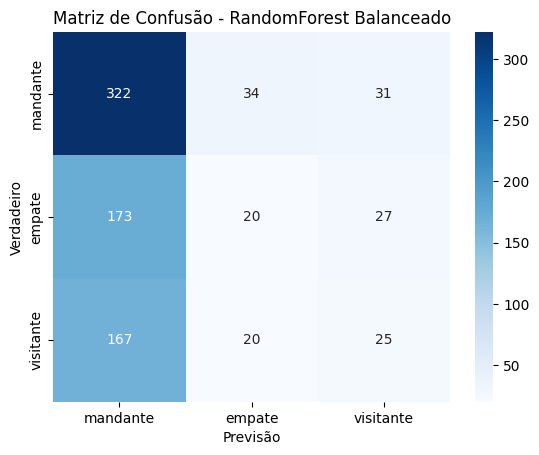

In [14]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

# Codificar y_train e y_valid
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

avaliar_modelo(modelo_rf, X_train, y_train, X_test, y_test, nome='RandomForest Balanceado')

### Treino e avaliação 2: XGBoost


📊 Avaliação do modelo: XGBoost
Accuracy: 0.4115
F1 Score: 0.3913

Classification Report:
              precision    recall  f1-score   support

      empate       0.30      0.24      0.27       220
    mandante       0.50      0.63      0.56       387
   visitante       0.27      0.19      0.22       212

    accuracy                           0.41       819
   macro avg       0.35      0.35      0.35       819
weighted avg       0.38      0.41      0.39       819



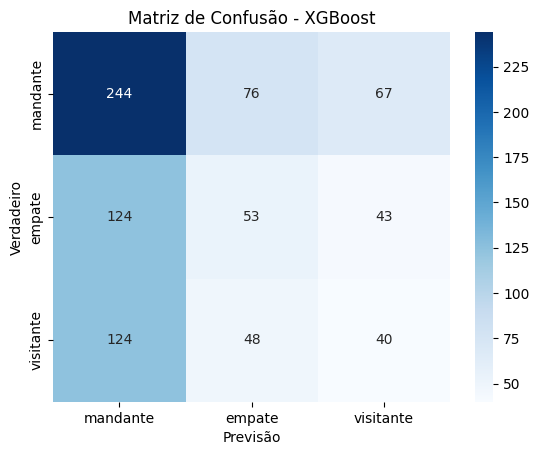

In [15]:
import xgboost as xgb

modelo_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

from sklearn.preprocessing import LabelEncoder

# Codificar y_train e y_valid
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

avaliar_modelo(modelo_xgb, X_train, y_train_encoded, X_test, y_test_encoded, nome='XGBoost')

### Treino e avaliação 3: LightGBM


📊 Avaliação do modelo: LightGBM
Accuracy: 0.4054
F1 Score: 0.3898

Classification Report:
              precision    recall  f1-score   support

      empate       0.29      0.25      0.27       220
    mandante       0.49      0.60      0.54       387
   visitante       0.29      0.21      0.24       212

    accuracy                           0.41       819
   macro avg       0.36      0.35      0.35       819
weighted avg       0.38      0.41      0.39       819



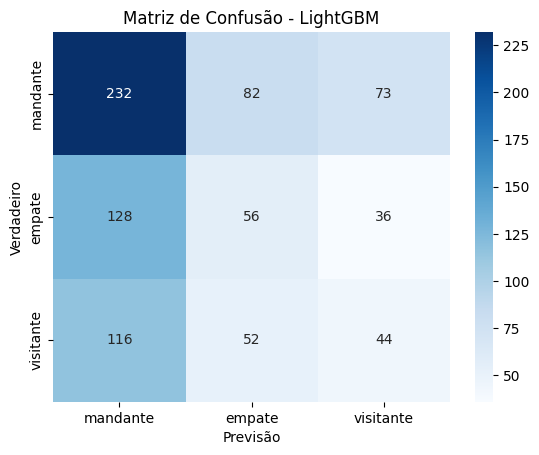

In [16]:
import lightgbm as lgb

modelo_lgbm = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

avaliar_modelo(modelo_lgbm, X_train, y_train, X_test, y_test, nome='LightGBM')

# Prevendo resultados da rodada atual

### Gerando resultados gerais e head to head até a data de hoje

In [17]:
# Define o número de jogos recentes a considerar
N = 10

# Inicializa listas
geral_mandante_jogos = []
geral_mandante_vitorias = []
geral_mandante_empates = []
geral_mandante_derrotas = []

geral_visitante_jogos = []
geral_visitante_vitorias = []
geral_visitante_empates = []
geral_visitante_derrotas = []

h2h_jogos = []
h2h_mandante_vitorias = []
h2h_visitante_vitorias = []
h2h_empates = []

# Loop
for idx, row in df_rodada_atual.iterrows():
    data_atual = pd.Timestamp.today()
    mandante = row['mandante']
    visitante = row['visitante']
    estadio = row['estadio']

    historico_passado = df_modelo_dinamico[df_modelo_dinamico['data_hora'] < data_atual]

    # Últimos N do mandante
    mandante_passado = historico_passado[historico_passado['mandante'] == mandante]
    mandante_passado = mandante_passado.sort_values('data_hora', ascending=False).head(N)
    geral_mandante_jogos.append(len(mandante_passado))
    geral_mandante_vitorias.append((mandante_passado['resultado_partida'] == 'mandante').sum())
    geral_mandante_empates.append((mandante_passado['resultado_partida'] == 'empate').sum())
    geral_mandante_derrotas.append((mandante_passado['resultado_partida'] == 'visitante').sum())

    # Últimos N do visitante
    visitante_passado = historico_passado[historico_passado['visitante'] == visitante]
    visitante_passado = visitante_passado.sort_values('data_hora', ascending=False).head(N)
    geral_visitante_jogos.append(len(visitante_passado))
    geral_visitante_vitorias.append((visitante_passado['resultado_partida'] == 'visitante').sum())
    geral_visitante_empates.append((visitante_passado['resultado_partida'] == 'empate').sum())
    geral_visitante_derrotas.append((visitante_passado['resultado_partida'] == 'mandante').sum())

    # H2H no estádio
    h2h_passado = historico_passado[
        (historico_passado['mandante'] == mandante) &
        (historico_passado['visitante'] == visitante) &
        (historico_passado['estadio'] == estadio)
    ]
    h2h_passado = h2h_passado.sort_values('data_hora', ascending=False)
    h2h_jogos.append(len(h2h_passado))
    h2h_mandante_vitorias.append((h2h_passado['resultado_partida'] == 'mandante').sum())
    h2h_visitante_vitorias.append((h2h_passado['resultado_partida'] == 'visitante').sum())
    h2h_empates.append((h2h_passado['resultado_partida'] == 'empate').sum())

# Copia e adiciona ao dataframe
df_rodada_atual = df_rodada_atual.copy()
df_rodada_atual['geral_mandante_jogos'] = geral_mandante_jogos
df_rodada_atual['geral_mandante_vitorias'] = geral_mandante_vitorias
df_rodada_atual['geral_mandante_empates'] = geral_mandante_empates
df_rodada_atual['geral_mandante_derrotas'] = geral_mandante_derrotas

df_rodada_atual['geral_visitante_jogos'] = geral_visitante_jogos
df_rodada_atual['geral_visitante_vitorias'] = geral_visitante_vitorias
df_rodada_atual['geral_visitante_empates'] = geral_visitante_empates
df_rodada_atual['geral_visitante_derrotas'] = geral_visitante_derrotas

df_rodada_atual['h2h_jogos'] = h2h_jogos
df_rodada_atual['h2h_mandante_vitorias'] = h2h_mandante_vitorias
df_rodada_atual['h2h_visitante_vitorias'] = h2h_visitante_vitorias
df_rodada_atual['h2h_empates'] = h2h_empates

print("✅ Features dinâmicas (últimos N jogos) adicionadas ao df_rodada_atual")


df_rodada_atual


✅ Features dinâmicas (últimos N jogos) adicionadas ao df_rodada_atual


,temporada,rodada,dia_semana,data_hora,estadio,publico,mandante,visitante,gols_mandante,gols_visitante,total_gols,resultado_partida,hora_hora,geral_mandante_jogos,geral_mandante_vitorias,geral_mandante_empates,geral_mandante_derrotas,geral_visitante_jogos,geral_visitante_vitorias,geral_visitante_empates,geral_visitante_derrotas,h2h_jogos,h2h_mandante_vitorias,h2h_visitante_vitorias,h2h_empates
0,2025,7,sáb,2025-05-03 18:30:00,Estadio Jornalista Mário Filho,0,Fluminense,Sport Recife,<NA>,<NA>,<NA>,None,18.0,10,5,4,1,10,1,1,8,6,3,1,2
1,2025,7,sáb,2025-05-03 18:30:00,Estádio Municipal Presidente Getúlio Var...,0,Ceará,Vitória,<NA>,<NA>,<NA>,None,18.0,10,4,3,3,10,3,5,2,0,0,0,0
2,2025,7,sáb,2025-05-03 18:30:00,Neo Química Arena,0,Corinthians,Internacional,<NA>,<NA>,<NA>,None,18.0,10,8,1,1,10,3,5,2,5,1,1,3
3,2025,7,sex,2025-05-02 21:30:00,Estádio do Morumbi,0,São Paulo,Fortaleza,<NA>,<NA>,<NA>,None,21.0,10,5,3,2,10,1,5,4,6,2,4,0
4,2025,7,dom,2025-05-04 16:00:00,Arena do Grêmio,0,Grêmio,Santos,<NA>,<NA>,<NA>,None,16.0,10,5,2,3,10,3,2,5,8,3,1,4
5,2025,7,dom,2025-05-04 16:00:00,Estádio Nacional de Brasília,0,Vasco da Gama,Palmeiras,<NA>,<NA>,<NA>,None,16.0,10,5,3,2,10,8,1,1,1,0,1,0
6,2025,7,dom,2025-05-04 18:30:00,Estádio Governador Magalhães Pinto,0,Cruzeiro,Flamengo,<NA>,<NA>,<NA>,None,18.0,10,4,3,3,10,6,3,1,6,1,4,1
7,2025,7,sáb,2025-05-03 21:00:00,Casa de Apostas Arena Fonte Nova,0,Bahia,Botafogo (RJ),<NA>,<NA>,<NA>,None,21.0,10,4,3,3,10,5,3,2,0,0,0,0
8,2025,7,seg,2025-05-05 19:00:00,Estádio Cicero de Souza Marques,0,RB Bragantino,Mirassol,<NA>,<NA>,<NA>,None,19.0,10,3,6,1,3,0,2,1,0,0,0,0
9,2025,7,seg,2025-05-05 20:00:00,Estádio Alfredo Jaconi,0,Juventude,Atlético Mineiro,<NA>,<NA>,<NA>,None,20.0,10,4,3,3,10,0,4,6,2,0,2,0


### Definindo colunas para prever e codificando as necessarias 

In [18]:
from sklearn.preprocessing import LabelEncoder

# --- Garantir cópia limpa ---
df_rodada_atual = df_rodada_atual.copy()

# --- Selecionar colunas usadas no treino ---
colunas_categoricas = ['mandante', 'visitante', 'estadio']
colunas_numericas = [
    'geral_mandante_jogos', 'geral_mandante_vitorias', 'geral_mandante_empates', 'geral_mandante_derrotas',
    'geral_visitante_jogos', 'geral_visitante_vitorias', 'geral_visitante_empates', 'geral_visitante_derrotas',
    'h2h_jogos', 'h2h_mandante_vitorias', 'h2h_visitante_vitorias', 'h2h_empates'
]

# --- Codificar categorias considerando históricos + novos valores ---
df_encoded_futuro = df_rodada_atual.copy()
for col in colunas_categoricas:
    le = LabelEncoder()
    todos_valores = pd.concat([df_modelo_dinamico[col], df_rodada_atual[col]]).unique()
    le.fit(todos_valores)
    df_encoded_futuro[col] = le.transform(df_encoded_futuro[col])


### Prevendo resultados do Modelo 1: RandomForestClassifier

In [19]:
# --- Montar X_futuro ---
X_futuro = df_encoded_futuro[colunas_categoricas + colunas_numericas]

# --- Fazer previsões ---
y_pred_futuro = modelo_rf.predict(X_futuro)
probs_futuro = modelo_rf.predict_proba(X_futuro)

# --- Adicionar previsões e probabilidades ao df_rodada_atual ---
df_rodada_atual['previsao_vencedor'] = y_pred_futuro
for i, classe in enumerate(le_y.classes_):
    df_rodada_atual[f'prob_{classe}'] = probs_futuro[:, i]

# --- Calcular confiança (probabilidade máxima) ---
df_rodada_atual['confiança'] = df_rodada_atual[
    [f'prob_{classe}' for classe in le_y.classes_]
].max(axis=1)

# --- Ordenar por confiança ---
df_rodada_atual = df_rodada_atual.sort_values(by='confiança', ascending=False).reset_index(drop=True)

# --- Mostrar top 5 ---
print("\n🔮 Previsões para todos os jogos da rodada:")

for i, row in df_rodada_atual.iterrows():
    partida = f"{row['mandante']} x {row['visitante']}"
    print(f"\nPartida: {partida}")
    print(f"Previsão: {row['previsao_vencedor']}")
    print(f"Probabilidades: {{'mandante': {row['prob_mandante']:.3f}, 'empate': {row['prob_empate']:.3f}, 'visitante': {row['prob_visitante']:.3f}}}")
    print(f"Confiança: {row['confiança']:.3f}")


🔮 Previsões para todos os jogos da rodada:

Partida: RB Bragantino x Mirassol
Previsão: mandante
Probabilidades: {'mandante': 0.535, 'empate': 0.236, 'visitante': 0.229}
Confiança: 0.535

Partida: Fluminense x Sport Recife
Previsão: mandante
Probabilidades: {'mandante': 0.491, 'empate': 0.248, 'visitante': 0.262}
Confiança: 0.491

Partida: Juventude x Atlético Mineiro
Previsão: mandante
Probabilidades: {'mandante': 0.448, 'empate': 0.304, 'visitante': 0.249}
Confiança: 0.448

Partida: Grêmio x Santos
Previsão: empate
Probabilidades: {'mandante': 0.378, 'empate': 0.417, 'visitante': 0.205}
Confiança: 0.417

Partida: São Paulo x Fortaleza
Previsão: mandante
Probabilidades: {'mandante': 0.412, 'empate': 0.359, 'visitante': 0.229}
Confiança: 0.412

Partida: Corinthians x Internacional
Previsão: mandante
Probabilidades: {'mandante': 0.409, 'empate': 0.313, 'visitante': 0.277}
Confiança: 0.409

Partida: Ceará x Vitória
Previsão: mandante
Probabilidades: {'mandante': 0.399, 'empate': 0.295, 